# 7 MUSCLES CLASSIFICATION + (INTER/INTRA)PERSONAL VALIDATION

In [2]:
# Installation of BioSignalsNotebooks
# %pip install biosignalsnotebooks
# %pip install tqdm

In [3]:
# Imports
import os
import glob
import shutil
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import biosignalsnotebooks as bsnb
# import plotly.graph_objects as go

# Tensorflow Model
import tensorflow as tf
from functools import reduce  # This is fine if you're using the 'reduce' function in your script
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Conv1D, LeakyReLU, MaxPooling1D, LSTM, GlobalAveragePooling1D, Dense, \
	Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy

# Weight and Biases
import wandb
from wandb.keras import WandbMetricsLogger

# Model Metrics
import seaborn as sn
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

## Creating the sEMG Signal Dataframes from the CSV files

In [4]:
# # Function to create a dataframe to store the data of every subject across all trials 
# def subject_df_creator(subject_id, muscles_of_interest):
#     trials_dfs_list = []
#     output_msg=[]
# 
#     for trial_number in tqdm(range(1, 51), desc=f"Concatenating trial Files for Subject AB{subject_id}"):
#         filename = f"5362627/AB{subject_id}/AB{subject_id}/Raw/AB{subject_id}_Circuit_0{trial_number:02d}_raw.csv"
#         if not os.path.exists(filename):  # Check if the file exists
#             output_msg.append(f"0{trial_number:02d}")
#             continue
# 
#         df_trial = pd.read_csv(filename)
#         df_trial_combined = pd.DataFrame()
# 
#         # Concatenate 'Right_' and 'Left_' values for each muscle of interest
#         for i in range(len(muscles_of_interest)):
#             df_trial_combined[muscles_of_interest[i]] = pd.concat([df_trial['Right_'+muscles_of_interest[i]], df_trial['Left_'+muscles_of_interest[i]]], ignore_index=True)
# 
#         trials_dfs_list.append(df_trial_combined)
# 
#     # Concatenate all DataFrames in the list along the rows axis
#     merged_df = pd.concat(trials_dfs_list, ignore_index=True)
#     if output_msg:
#         print(f"{len(output_msg)} Files do not exist:", output_msg)
#     return merged_df

In [5]:
# Defining important lists
subjects = ["156", "185", "186", "188", "189", "190", "191", "192", "193", "194"]
muscles = ['TA', 'MG', 'SOL', 'BF', 'ST', 'VL', 'RF']

In [6]:
# # Creating dataframes to save subject-specific data
# df_subject_156 = subject_df_creator("156", muscles)
# df_subject_185 = subject_df_creator("185", muscles)
# df_subject_186 = subject_df_creator("186", muscles)
# df_subject_188 = subject_df_creator("188", muscles)
# df_subject_189 = subject_df_creator("189", muscles)
# df_subject_190 = subject_df_creator("190", muscles)
# df_subject_191 = subject_df_creator("191", muscles)
# df_subject_192 = subject_df_creator("192", muscles)
# df_subject_193 = subject_df_creator("193", muscles)
# df_subject_194 = subject_df_creator("194", muscles)

In [7]:
# # Saving the Dataframes into pickle objects to save time
# df_subject_156.to_pickle('pickled_dataframes/df_subject_156.pkl')
# df_subject_185.to_pickle('pickled_dataframes/df_subject_185.pkl')
# df_subject_186.to_pickle('pickled_dataframes/df_subject_186.pkl')
# df_subject_188.to_pickle('pickled_dataframes/df_subject_188.pkl')
# df_subject_189.to_pickle('pickled_dataframes/df_subject_189.pkl')
# df_subject_190.to_pickle('pickled_dataframes/df_subject_190.pkl')
# df_subject_191.to_pickle('pickled_dataframes/df_subject_191.pkl')
# df_subject_192.to_pickle('pickled_dataframes/df_subject_192.pkl')
# df_subject_193.to_pickle('pickled_dataframes/df_subject_193.pkl')
# df_subject_194.to_pickle('pickled_dataframes/df_subject_194.pkl')

In [8]:
# # Loading pickle files into DataFrames
# df_subject_156 = pd.read_pickle('pickled_dataframes/df_subject_156.pkl')
# df_subject_185 = pd.read_pickle('pickled_dataframes/df_subject_185.pkl')
# df_subject_186 = pd.read_pickle('pickled_dataframes/df_subject_186.pkl')
# df_subject_188 = pd.read_pickle('pickled_dataframes/df_subject_188.pkl')
# df_subject_189 = pd.read_pickle('pickled_dataframes/df_subject_189.pkl')
# df_subject_190 = pd.read_pickle('pickled_dataframes/df_subject_190.pkl')
# df_subject_191 = pd.read_pickle('pickled_dataframes/df_subject_191.pkl')
# df_subject_192 = pd.read_pickle('pickled_dataframes/df_subject_192.pkl')
# df_subject_193 = pd.read_pickle('pickled_dataframes/df_subject_193.pkl')
# df_subject_194 = pd.read_pickle('pickled_dataframes/df_subject_194.pkl')

In [9]:
# # Merging all the subject dataframes into one
# list_of_all_subjects_dfs = [df_subject_156, df_subject_185, df_subject_186, df_subject_188, df_subject_189,
#                             df_subject_190, df_subject_191, df_subject_192, df_subject_193, df_subject_194]
# 
# df_all_subjects = pd.concat(list_of_all_subjects_dfs, ignore_index=True)

In [102]:
# df_all_subjects

## EMG Signal Visualisation 

In [11]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x=df_all_subjects.index/1000, y=df_all_subjects['TA'][60000:90000]))
# fig1.update_layout( title="sEMG Signal: Sitting Vs Contraction Bursts Vs Rest", xaxis_title="Time (s)",
#                     yaxis_title="sEMG Activity (V)", margin=dict(l=50, r=50, b=50, t=50, pad=4),
#                     autosize=False, width=800, height=301)
# # plotting
# fig1.show()

## EMG Signal Analysis

In [103]:
# # Studying mean, sigma and variance of the 2 Muscles
# df_analysis = pd.DataFrame()
# df_analysis['Mean'] = df_all_subjects.mean()
# df_analysis['Std'] = df_all_subjects.std()
# df_analysis['Var'] = df_all_subjects.var()
# df_analysis

## Burst Detection

In [104]:
# # Saving the detected bursts for every muscle 
# sr = 1000 # sample rate = 1000Hz
# sl = 20 # smooth level (Size of sliding window used during the moving average process) #used to be 40
# th = 10 # threshold (To cover activation)
# 
# # Initializing lists
# detected_bursts_TA = [] ; detected_bursts_MG = [] ; detected_bursts_SOL= []
# detected_bursts_BF = [] ; detected_bursts_ST = [] ; detected_bursts_VL = []
# detected_bursts_RF = []
# 
# pbar = tqdm(total=len(muscles)*len(list_of_all_subjects_dfs), desc="All Subjects Burst Detection Progress", unit= "Muscle")
# for df_subject in list_of_all_subjects_dfs:
#     ## TA
#     detected_bursts_TA.append(bsnb.detect_emg_activations(emg_signal=df_subject['TA'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)  # Update progress bar
#     ## MG
#     detected_bursts_MG.append(bsnb.detect_emg_activations(emg_signal=df_subject['MG'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## SOL
#     detected_bursts_SOL.append(bsnb.detect_emg_activations(emg_signal=df_subject['SOL'], sample_rate=sr, smooth_level=sl,
#                                                            threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## BF
#     detected_bursts_BF.append(bsnb.detect_emg_activations(emg_signal=df_subject['BF'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## ST
#     detected_bursts_ST.append(bsnb.detect_emg_activations(emg_signal=df_subject['ST'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## VL
#     detected_bursts_VL.append(bsnb.detect_emg_activations(emg_signal=df_subject['VL'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## RF
#     detected_bursts_RF.append(bsnb.detect_emg_activations(emg_signal=df_subject['RF'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)

In [14]:
# # Creating the pickles to save the burst detection results (saves 29 minutes)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_TA.pkl', 'wb') as f: pickle.dump(detected_bursts_TA, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_MG.pkl', 'wb') as f: pickle.dump(detected_bursts_MG, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_SOL.pkl','wb') as f: pickle.dump(detected_bursts_SOL,f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_BF.pkl', 'wb') as f: pickle.dump(detected_bursts_BF, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_ST.pkl', 'wb') as f: pickle.dump(detected_bursts_ST, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_VL.pkl', 'wb') as f: pickle.dump(detected_bursts_VL, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_RF.pkl', 'wb') as f: pickle.dump(detected_bursts_RF, f)

In [15]:
# # Loading the pickles
# pbar = tqdm(total=len(muscles), desc="Burst Detection Loading Progress", unit= "Muscle")
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_TA.pkl', 'rb') as f: detected_bursts_TA = pickle.load(f)
# pbar.update(1)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_MG.pkl', 'rb') as f: detected_bursts_MG = pickle.load(f)
# pbar.update(1)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_SOL.pkl','rb') as f: detected_bursts_SOL= pickle.load(f)
# pbar.update(1)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_BF.pkl', 'rb') as f: detected_bursts_BF = pickle.load(f)
# pbar.update(1)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_ST.pkl', 'rb') as f: detected_bursts_ST = pickle.load(f)
# pbar.update(1)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_VL.pkl', 'rb') as f: detected_bursts_VL = pickle.load(f)
# pbar.update(1)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_RF.pkl', 'rb') as f: detected_bursts_RF = pickle.load(f)
# pbar.update(1)

Burst Detection Loading Progress:   0%|          | 0/7 [00:00<?, ?Muscle/s]

True

In [16]:
# pd.DataFrame(detected_bursts_SOL[:][:10]).transpose()

## Detected Bursts Visualisation

In [17]:
# # Visualising the EMG Burst Detection for SOL
# plot_duration = 40000 # time in milliseconds
# bsnb.detect_emg_activations(emg_signal = df_all_subjects['SOL'][:plot_duration], sample_rate = sr, smooth_level=sl, threshold_level=th, time_units=True, device='CH0', plot_result= True)
# print('')

In [105]:
# # Visualizing First Activations -> SEE CAPTURED WINDOW WITH RESPECT OF IDENTIFIED ACTIVATION
# duration = 8000
# shift = 2000
# number_bursts_to_plot = 1
# 
# plt.rcParams["figure.figsize"] = (10,5)
# fig = plt.figure()
# 
# plt.plot(df_all_subjects['TA'][:duration], color="cornflowerblue")
# for i in range(number_bursts_to_plot): # Plot first N bursts
#     plt.axvline(detected_bursts_TA[0][i]*1000,color='red', label="Detected Burst Region") # ONSET VERTICAL LINE
#     plt.axvline(detected_bursts_TA[1][i]*1000,color='red') # OFFSET VERTICAL LINE
#     plt.axvline(detected_bursts_TA[0][i]*1000+400,color='black', label="Onset Window (700ms)") # ONSET VERTICAL LINE CORRECTED (START WINDOW)
#     plt.axvline(detected_bursts_TA[0][i]*1000-100,color='black') # VERTICAL LINE (END WINDOW)
# 
# plt.legend(loc="upper left")
# plt.xlim(shift,duration)
# plt.grid()
# plt.xlabel('Time (ms)', fontsize=10)
# plt.ylabel('sEMG Intensity (V)', fontsize=10)
# 
# # plt.savefig("Window.png")

In [19]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x = df_all_subjects.index/1000 , y=df_all_subjects['Left_TA'][:10000]))
# 
# # formatting the plot
# fig1.update_layout(autosize=True, title="sEMG Signal: Detected burst and corrected onset window",
#                    xaxis_title="Time (s)", yaxis_title="sEMG Activity (V)", margin=dict(l=50, r=50, b=50, t=50, pad=4))
# 
# fig1.add_vrect(x0=detected_bursts_TA[0][0], x1=detected_bursts_left_TA[1][0], row="all", col=1,
#                annotation_text="Detected Burst", annotation_position="top right", fillcolor="gray",
#                opacity=0.25, line_width=0)
# 
# fig1.add_vline(x=detected_bursts_left_TA[0][0]+0.4,line_width=1.5, line_dash="dot", line_color="red")
# fig1.add_vline(x=detected_bursts_left_TA[0][0]-0.1,line_width=1.5, line_dash="dot", line_color="red",
#                annotation_text="Onset Window",annotation_position="bottom right")
# 
# # fig1.update_xaxes(range=[7.5, 20000/1000])
# # fig1.update_yaxes(range=[-2, 2])
# fig1.update_layout(autosize=False, width=800, height=301)
# # plotting
# fig1.show()

In [20]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x= df_all_subjects.index/1000, y=df_all_subjects['TA']))
# # formatting the plot
# fig1.update_layout(autosize=True, title="sEMG Signal: Detection of Activation Bursts",
#                    xaxis_title="Time (s)", yaxis_title="sEMG Activity (V)",
#                    margin=dict(l=50, r=50, b=50, t=50, pad=4))
# 
# for i in range(len(detected_bursts_TA[0])):
#     fig1.add_vrect(x0=detected_bursts_TA[0][i], x1=detected_bursts_TA[1][i], row="all", col=1,
#                    annotation_text="Detected Burst", annotation_position="top right",
#                    fillcolor="black", opacity=0.25, line_width=0)
# 
# # fig1.update_xaxes(range=[30, 60])
# fig1.update_layout(autosize=False, width=800, height=301)
# # plotting
# fig1.show()

## Detected Bursts Analysis 

### Number of Detected Bursts

In [106]:
# # Defining Variables to store the total number of bursts for every muscle 
# tot_bursts_TA = [] ; tot_bursts_MG = [] ; tot_bursts_SOL = []
# tot_bursts_BF = [] ; tot_bursts_ST = [] ; tot_bursts_VL = []
# tot_bursts_RF = [] ; burst_count_list_for_printing = []
# 
# # Calculating the total number of bursts per muscle
# for subject_idx, subject in enumerate(subjects):
#     tot_bursts_TA.append(len(detected_bursts_TA[subject_idx][0]))
#     tot_bursts_MG.append(len(detected_bursts_MG[subject_idx][0]))
#     tot_bursts_SOL.append(len(detected_bursts_SOL[subject_idx][0]))
#     tot_bursts_BF.append(len(detected_bursts_BF[subject_idx][0]))
#     tot_bursts_ST.append(len(detected_bursts_ST[subject_idx][0]))
#     tot_bursts_VL.append(len(detected_bursts_VL[subject_idx][0]))
#     tot_bursts_RF.append(len(detected_bursts_RF[subject_idx][0]))
# 
#     # Calculate the total bursts for each subject across all muscles
#     total_bursts_subject = (tot_bursts_TA[subject_idx] + tot_bursts_MG[subject_idx] +
#                             tot_bursts_SOL[subject_idx] + tot_bursts_BF[subject_idx] +
#                             tot_bursts_ST[subject_idx] + tot_bursts_VL[subject_idx] +
#                             tot_bursts_RF[subject_idx])
# 
#     # Saving the results in a list for fancy printing
#     burst_count_list_for_printing.append([subject, tot_bursts_TA[subject_idx], tot_bursts_MG[subject_idx], tot_bursts_SOL[subject_idx],
#                                           tot_bursts_BF[subject_idx], tot_bursts_ST[subject_idx], tot_bursts_VL[subject_idx],
#                                           tot_bursts_RF[subject_idx], total_bursts_subject])
# 
# # Adding the total row to the printing
# burst_count_list_for_printing.append(['* Total Sum', sum(tot_bursts_TA), sum(tot_bursts_MG), sum(tot_bursts_SOL), sum(tot_bursts_BF),
#                                       sum(tot_bursts_ST), sum(tot_bursts_VL), sum(tot_bursts_RF),
#                                       sum(tot_bursts_TA) + sum(tot_bursts_MG) + sum(tot_bursts_SOL) + sum(tot_bursts_BF) +
#                                       sum(tot_bursts_ST) + sum(tot_bursts_VL) + sum(tot_bursts_RF)])
# 
# # Printing the table
# print("Number of Muscle Bursts Per Subject Per Muscle:\n")
# headers = ["Subject", "TA Bursts", "MG Bursts", "SOL Bursts", "BF Bursts", "ST Bursts", "VL Bursts", "RF Bursts", "Total Bursts"]
# print(tabulate(burst_count_list_for_printing, headers=headers, tablefmt='grid'))

### Longest Detected Bursts

In [107]:
# # Lists to store longest burst per muscle for all subjects
# longest_bursts_TA = []; longest_bursts_MG = []; longest_bursts_SOL = []
# longest_bursts_BF = []; longest_bursts_ST = []; longest_bursts_VL = []
# longest_bursts_RF = []
# longest_burst_list_for_printing = []
# 
# # Calculating the longest burst per muscle
# for subject_idx, subject in enumerate(subjects):
#     longest_TA = max(np.array(detected_bursts_TA[subject_idx][1])-np.array(detected_bursts_TA[subject_idx][0]))
#     longest_MG = max(np.array(detected_bursts_MG[subject_idx][1])-np.array(detected_bursts_MG[subject_idx][0]))
#     longest_SOL = max(np.array(detected_bursts_SOL[subject_idx][1])-np.array(detected_bursts_SOL[subject_idx][0]))
#     longest_BF = max(np.array(detected_bursts_BF[subject_idx][1])-np.array(detected_bursts_BF[subject_idx][0]))
#     longest_ST = max(np.array(detected_bursts_ST[subject_idx][1])-np.array(detected_bursts_ST[subject_idx][0]))
#     longest_VL = max(np.array(detected_bursts_VL[subject_idx][1])-np.array(detected_bursts_VL[subject_idx][0]))
#     longest_RF = max(np.array(detected_bursts_RF[subject_idx][1])-np.array(detected_bursts_RF[subject_idx][0]))
# 
#     # Save longest burst per muscle for this subject
#     longest_bursts_TA.append(longest_TA)
#     longest_bursts_MG.append(longest_MG)
#     longest_bursts_SOL.append(longest_SOL)
#     longest_bursts_BF.append(longest_BF)
#     longest_bursts_ST.append(longest_ST)
#     longest_bursts_VL.append(longest_VL)
#     longest_bursts_RF.append(longest_RF)
# 
#     # Calculate the longest burst across all muscles for the subject
#     longest_burst_subject = max(longest_TA, longest_MG, longest_SOL, longest_BF, longest_ST, longest_VL, longest_RF)
# 
#     # Save the results in a list for printing
#     longest_burst_list_for_printing.append([subject, longest_TA, longest_MG, longest_SOL, longest_BF, longest_ST, longest_VL, longest_RF, longest_burst_subject])
# 
# # Adding the longest burst across all subjects per muscle and overall
# longest_burst_list_for_printing.append(['* Longest Burst', max(longest_bursts_TA), max(longest_bursts_MG),
#                                         max(longest_bursts_SOL), max(longest_bursts_BF),
#                                         max(longest_bursts_ST), max(longest_bursts_VL),
#                                         max(longest_bursts_RF), max([max(longest_bursts_TA), max(longest_bursts_MG), max(longest_bursts_SOL),
#                                                                      max(longest_bursts_BF), max(longest_bursts_ST), max(longest_bursts_VL), max(longest_bursts_RF)])])
# 
# # Printing the table
# print("Longest Burst Per Subject Per Muscle:\n")
# headers = ["Subject", "TA (s)", "MG (s)", "SOL (s)", "BF (s)", "ST (s)", "VL (s)", "RF (s)", "Per Subject (s)"]
# print(tabulate(longest_burst_list_for_printing, headers=headers, tablefmt='grid'))

Longest Burst Per Subject Per Muscle:

+-----------------+----------+----------+-----------+----------+----------+----------+----------+-------------------+
| Subject         |   TA (s) |   MG (s) |   SOL (s) |   BF (s) |   ST (s) |   VL (s) |   RF (s) |   Per Subject (s) |
+=================+==========+==========+===========+==========+==========+==========+==========+===================+
| 156             |    2.439 |    2.515 |     1.666 |    6.978 |    1.549 |    1.3   |    1.136 |             6.978 |
+-----------------+----------+----------+-----------+----------+----------+----------+----------+-------------------+
| 185             |    2.144 |    1.145 |     2.081 |    1.206 |    2.13  |    6.104 |    7.858 |             7.858 |
+-----------------+----------+----------+-----------+----------+----------+----------+----------+-------------------+
| 186             |    3.562 |    1.2   |     6.879 |    1.339 |    1.393 |    2.755 |   14.415 |            14.415 |
+----------------

### Average Detected Bursts Lengths

In [96]:
# # Lists to store average burst length per muscle for all subjects
# average_burst_lengths_TA = [] ; average_burst_lengths_MG = []
# average_burst_lengths_SOL = []; average_burst_lengths_BF = []
# average_burst_lengths_ST = [] ; average_burst_lengths_VL = []
# average_burst_lengths_RF = [] ; avg_burst_len_list_for_printing = []
# 
# # Maximum allowed burst duration
# max_duration = 2
# 
# # Calculating average burst length per muscle, excluding bursts longer than 2 seconds
# for subject_idx, subject in enumerate(subjects):
#     bursts_TA = np.array(detected_bursts_TA[subject_idx][1]) - np.array(detected_bursts_TA[subject_idx][0])
#     bursts_MG = np.array(detected_bursts_MG[subject_idx][1]) - np.array(detected_bursts_MG[subject_idx][0])
#     bursts_SOL = np.array(detected_bursts_SOL[subject_idx][1]) - np.array(detected_bursts_SOL[subject_idx][0])
#     bursts_BF = np.array(detected_bursts_BF[subject_idx][1]) - np.array(detected_bursts_BF[subject_idx][0])
#     bursts_ST = np.array(detected_bursts_ST[subject_idx][1]) - np.array(detected_bursts_ST[subject_idx][0])
#     bursts_VL = np.array(detected_bursts_VL[subject_idx][1]) - np.array(detected_bursts_VL[subject_idx][0])
#     bursts_RF = np.array(detected_bursts_RF[subject_idx][1]) - np.array(detected_bursts_RF[subject_idx][0])
# 
#     # Filter bursts longer than 2 seconds
#     filtered_bursts_TA = bursts_TA[bursts_TA <= max_duration]
#     filtered_bursts_MG = bursts_MG[bursts_MG <= max_duration]
#     filtered_bursts_SOL = bursts_SOL[bursts_SOL <= max_duration]
#     filtered_bursts_BF = bursts_BF[bursts_BF <= max_duration]
#     filtered_bursts_ST = bursts_ST[bursts_ST <= max_duration]
#     filtered_bursts_VL = bursts_VL[bursts_VL <= max_duration]
#     filtered_bursts_RF = bursts_RF[bursts_RF <= max_duration]
# 
#     # Calculate mean of filtered bursts
#     mean_TA = np.mean(filtered_bursts_TA)
#     mean_MG = np.mean(filtered_bursts_MG)
#     mean_SOL = np.mean(filtered_bursts_SOL)
#     mean_BF = np.mean(filtered_bursts_BF)
#     mean_ST = np.mean(filtered_bursts_ST)
#     mean_VL = np.mean(filtered_bursts_VL)
#     mean_RF = np.mean(filtered_bursts_RF)
# 
#     average_burst_lengths_TA.append(mean_TA)
#     average_burst_lengths_MG.append(mean_MG)
#     average_burst_lengths_SOL.append(mean_SOL)
#     average_burst_lengths_BF.append(mean_BF)
#     average_burst_lengths_ST.append(mean_ST)
#     average_burst_lengths_VL.append(mean_VL)
#     average_burst_lengths_RF.append(mean_RF)
# 
#     # Calculate the average for the subject across all muscles
#     subject_average = np.mean([mean_TA, mean_MG, mean_SOL, mean_BF, mean_ST, mean_VL, mean_RF])
# 
#     # Saving the results in a list for fancy printing
#     avg_burst_len_list_for_printing.append([subject,
#                                             round(mean_TA, 3),
#                                             round(mean_MG, 3),
#                                             round(mean_SOL, 3),
#                                             round(mean_BF, 3),
#                                             round(mean_ST, 3),
#                                             round(mean_VL, 3),
#                                             round(mean_RF, 3),
#                                             round(subject_average, 3)])  # Include average per subject
# 
# # Adding the total row to the printing
# avg_burst_len_list_for_printing.append(['* Avg. Len', round(np.mean(average_burst_lengths_TA), 3), round(np.mean(average_burst_lengths_MG), 3),
#                                         round(np.mean(average_burst_lengths_SOL), 3), round(np.mean(average_burst_lengths_BF), 3),
#                                         round(np.mean(average_burst_lengths_ST), 3), round(np.mean(average_burst_lengths_VL), 3),
#                                         round(np.mean(average_burst_lengths_RF), 3)])
# # Calculate the overall average length and append to the list for printing
# avg_burst_len_list_for_printing.append(['* Overall Avg. Len', round(np.mean(average_burst_lengths_TA + average_burst_lengths_MG + average_burst_lengths_SOL + average_burst_lengths_BF + average_burst_lengths_ST + average_burst_lengths_VL + average_burst_lengths_RF), 3)])
# 
# # Printing the table
# print(f"Average Burst Length in Seconds Per Subject Per Muscle (Excluding Muscle Bursts Longer than {max_duration} Seconds):\n")
# headers = ["Subject", "TA Avg.Len", "MG Avg.Len", "SOL Avg.Len", "BF Avg.Len", "ST Avg.Len", "VL Avg.Len", "RF Avg.Len", "Avg. Per Subject"]
# print(tabulate(avg_burst_len_list_for_printing, headers=headers, tablefmt='grid'))

Average Burst Length in Seconds Per Subject Per Muscle (Excluding Muscle Bursts Longer than 2 Seconds):

+--------------------+--------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------------+
| Subject            |   TA Avg.Len |   MG Avg.Len |   SOL Avg.Len |   BF Avg.Len |   ST Avg.Len |   VL Avg.Len |   RF Avg.Len |   Avg. Per Subject |
+====================+==============+==============+===============+==============+==============+==============+==============+====================+
| 156                |        0.457 |        0.472 |         0.381 |        0.564 |        0.279 |        0.515 |        0.438 |              0.444 |
+--------------------+--------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------------+
| 185                |        0.465 |        0.459 |         0.497 |        0.439 |        0.42  |        0.542 |        0.568 |              0.4

### Histogram: Detected Bursts Lengths

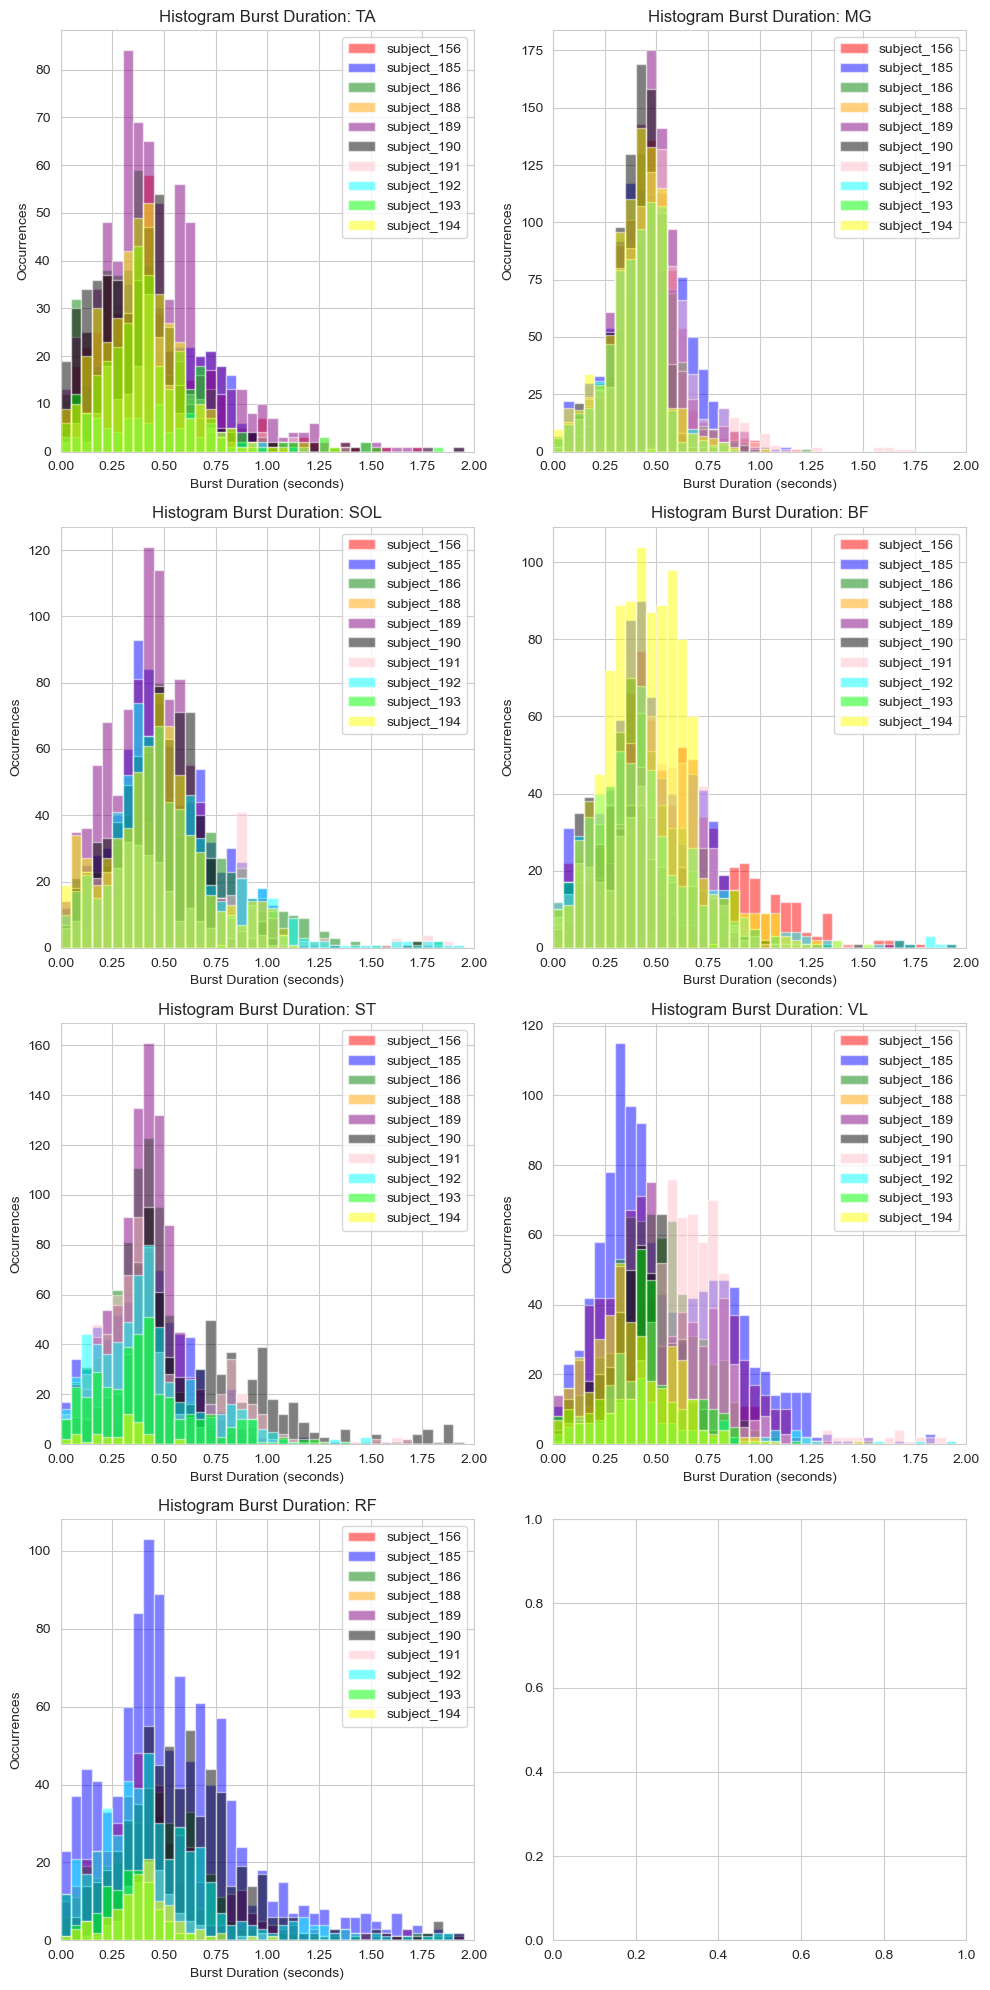

In [24]:
# # Adjust subplot indexing
# f, a = plt.subplots(4, 2)
# f.set_size_inches(10, 20)
# a = a.ravel()
# bin_edges = np.arange(start=0, stop=2, step=0.05)  # Example for bins of width 0.05
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'pink', 'cyan', 'lime', 'yellow']
# 
# for subject_idx, subject in enumerate(subjects):
# 	subject = "subject_" + subject
# 	a[0].hist(np.array(detected_bursts_TA[subject_idx][1])-np.array(detected_bursts_TA[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
# 	a[1].hist(np.array(detected_bursts_MG[subject_idx][1])-np.array(detected_bursts_MG[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
# 	a[2].hist(np.array(detected_bursts_SOL[subject_idx][1])-np.array(detected_bursts_SOL[subject_idx][0]),bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
# 	a[3].hist(np.array(detected_bursts_BF[subject_idx][1])-np.array(detected_bursts_BF[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
# 	a[4].hist(np.array(detected_bursts_ST[subject_idx][1])-np.array(detected_bursts_ST[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
# 	a[5].hist(np.array(detected_bursts_VL[subject_idx][1])-np.array(detected_bursts_VL[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
# 	a[6].hist(np.array(detected_bursts_RF[subject_idx][1])-np.array(detected_bursts_RF[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
# 
# # Set legends, titles, and labels for each subplot
# for muscle_idx, muscle in enumerate(muscles):
# 	a[muscle_idx].legend(loc='upper right')
# 	a[muscle_idx].set_title('Histogram Burst Duration: ' + muscle)
# 	a[muscle_idx].set_xlabel("Burst Duration (seconds)")
# 	a[muscle_idx].set_ylabel("Occurrences")
# 	a[muscle_idx].set_xlim([0, 2])  # Remove to see how bad the burst detection is 
# 
# plt.tight_layout()
# plt.show()

# Extracting Bursts

### Method: Using a Window size of 700ms including an onset of 100ms

In [25]:
# def extract_burst_windows(muscle_emg_signal, onset_list, window_size, left_shift_value, muscle_name):
# 	sampling_rate = 1000
# 	all_subjects_burst_samples = []
# 	for subject_index in tqdm(range(len(onset_list)), desc=f"Extracting Bursts for {muscle_name}"):
# 		current_subject_bursts = []
# 		ii = -1
# 		for onset in onset_list[subject_index][0]:
# 			ii += 1
# 			onset_ms = int(onset * sampling_rate) - left_shift_value
# 			current_sample_window = []
# 			if onset != onset_list[subject_index][0][-1]:
# 				if (onset_ms + window_size) < (onset_list[subject_index][0][ii + 1] * 1000):
# 					for time_step in range(window_size):
# 						current_sample_window.append(muscle_emg_signal[onset_ms + time_step])
# 			else:
# 				for time_step in range(window_size):
# 					current_sample_window.append(muscle_emg_signal[onset_ms + time_step])
# 
# 			if current_sample_window:
# 				current_sample_window -= np.mean(current_sample_window)
# 				current_subject_bursts.append(current_sample_window)
# 		all_subjects_burst_samples.append(current_subject_bursts)
# 	return all_subjects_burst_samples

In [26]:
window = 700 # in ms (total window size)
left_shift = 100 # in ms (left shift from detected onset). See detected onset on the vertical red lines in the plots above

In [27]:
# fixed_bursts_TA = extract_burst_windows(df_all_subjects['TA'], detected_bursts_TA, window, left_shift, 'TA')
# fixed_bursts_MG = extract_burst_windows(df_all_subjects['MG'], detected_bursts_MG, window, left_shift, 'MG')
# fixed_bursts_SOL= extract_burst_windows(df_all_subjects['SOL'],detected_bursts_SOL,window, left_shift, 'SOL')
# fixed_bursts_BF = extract_burst_windows(df_all_subjects['BF'], detected_bursts_BF, window, left_shift, 'BF')
# fixed_bursts_ST = extract_burst_windows(df_all_subjects['ST'], detected_bursts_ST, window, left_shift, 'ST')
# fixed_bursts_VL = extract_burst_windows(df_all_subjects['VL'], detected_bursts_VL, window, left_shift, 'VL')
# fixed_bursts_RF = extract_burst_windows(df_all_subjects['RF'], detected_bursts_RF, window, left_shift, 'RF')

Extracting Bursts for TA:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for MG:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for SOL:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for BF:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for ST:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for VL:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting Bursts for RF:   0%|          | 0/10 [00:00<?, ?it/s]

In [99]:
# # Defining Variables to store the total number of bursts for every muscle 
# tot_bursts_TA = []; tot_bursts_MG = []; tot_bursts_SOL = []; tot_bursts_BF = []
# tot_bursts_ST = []; tot_bursts_VL = []; tot_bursts_RF = []
# burst_count_list_for_printing = []
# 
# # Calculating the total number of bursts per muscle
# for subject_idx, subject in enumerate(subjects):
#     tot_bursts_TA.append(len(fixed_bursts_TA[subject_idx]))
#     tot_bursts_MG.append(len(fixed_bursts_MG[subject_idx]))
#     tot_bursts_SOL.append(len(fixed_bursts_SOL[subject_idx]))
#     tot_bursts_BF.append(len(fixed_bursts_BF[subject_idx]))
#     tot_bursts_ST.append(len(fixed_bursts_ST[subject_idx]))
#     tot_bursts_VL.append(len(fixed_bursts_VL[subject_idx]))
#     tot_bursts_RF.append(len(fixed_bursts_RF[subject_idx]))
# 
#     # Calculate the total bursts for each subject across all muscles
#     total_bursts_subject = (tot_bursts_TA[subject_idx] + tot_bursts_MG[subject_idx] +
#                             tot_bursts_SOL[subject_idx] + tot_bursts_BF[subject_idx] +
#                             tot_bursts_ST[subject_idx] + tot_bursts_VL[subject_idx] +
#                             tot_bursts_RF[subject_idx])
# 
#     # Saving the results in a list for fancy printing
#     burst_count_list_for_printing.append([subject, tot_bursts_TA[subject_idx], tot_bursts_MG[subject_idx], tot_bursts_SOL[subject_idx],
#                                           tot_bursts_BF[subject_idx], tot_bursts_ST[subject_idx], tot_bursts_VL[subject_idx],
#                                           tot_bursts_RF[subject_idx], total_bursts_subject])
# 
# # Adding the total row to the printing
# total_sum = [sum(tot_bursts_TA), sum(tot_bursts_MG), sum(tot_bursts_SOL), sum(tot_bursts_BF), sum(tot_bursts_ST), sum(tot_bursts_VL), sum(tot_bursts_RF)]
# total_sum.append(sum(total_sum))  # Add total of totals
# burst_count_list_for_printing.append(['* Total Sum'] + total_sum)
# 
# # Printing the table
# print("Number of Muscle Bursts Per Subject Per Muscle:\n")
# headers = ["Subject", "TA Bursts", "MG Bursts", "SOL Bursts", "BF Bursts", "ST Bursts", "VL Bursts", "RF Bursts", "Total Per Subject"]
# print(tabulate(burst_count_list_for_printing, headers=headers, tablefmt="grid"))

Number of Muscle Bursts Per Subject Per Muscle:

+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+---------------------+
| Subject     |   TA Bursts |   MG Bursts |   SOL Bursts |   BF Bursts |   ST Bursts |   VL Bursts |   RF Bursts |   Total Per Subject |
+=============+=============+=============+==============+=============+=============+=============+=============+=====================+
| 156         |         437 |         753 |          295 |         786 |          39 |         213 |         156 |                2679 |
+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+---------------------+
| 185         |         397 |         940 |          798 |         708 |         701 |        1007 |        1006 |                5557 |
+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+---------------

# TFRecords: Storing Training and Validation Datasets in Tensorflow Records

Reference: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/tfrecord.ipynb#scrollTo=_e3g9ExathXP

## Write TFRecords

In [29]:
# def _float_feature(value):
# 	"""Returns a float_list from a float / double."""
# 	return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
# 
# def _int64_feature(value):
# 	"""Returns an int64_list from a bool / enum / int / uint."""
# 	return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
# 
# def extract_burst_windows_tfrecord(emg_series_complete, onset_lists, window_size, left_shift_value):
# 	# Ensure unique file names for parallel processing or repeated calls
# 	file_name = f'tfrecords/all_dataset_{window}ms.tfrecord'
# 	with tf.io.TFRecordWriter(file_name) as tfrecord:
# 		for muscle_index in tqdm(range(len(emg_series_complete)), desc="Extracting dataset to TFRecords (Fixed Window)"):
# 			for subject_index in range(len(onset_lists[muscle_index])):
# 				burst_count = 0
# 				ii = -1
# 				for onset in onset_lists[muscle_index][subject_index][0]:
# 					ii += 1
# 					onset_ms = int(onset * 1000) - left_shift_value
# 					current_sample_window = []
# 					if onset != onset_lists[muscle_index][subject_index][0][-1]:
# 						if (onset_ms + window_size) < (onset_lists[muscle_index][subject_index][0][ii + 1] * 1000):
# 							burst_count = burst_count + 1
# 							for time_step in range(window_size):
# 								current_sample_window.append(emg_series_complete[muscle_index][onset_ms + time_step])
# 					else:
# 						burst_count = burst_count + 1
# 						for time_step in range(window_size):
# 							current_sample_window.append(emg_series_complete[muscle_index][onset_ms + time_step])
# 
# 					if current_sample_window:
# 						current_sample_window -= np.mean(current_sample_window)
# 						# Convert your sample and label to appropriate tf.train.Feature formats
# 						features = {
# 							'label': _int64_feature(muscle_index),
# 							'feature': tf.train.Feature(float_list=tf.train.FloatList(value=current_sample_window)),
# 							'subject': _int64_feature(subject_index + 1),
# 							'burst': _int64_feature(burst_count)
# 						}
# 						example = tf.train.Example(features=tf.train.Features(feature=features))
# 						tfrecord.write(example.SerializeToString())
# 	return file_name

In [30]:
# # .....
# emg_series_tot = [df_all_subjects['TA'], df_all_subjects['MG'], df_all_subjects['SOL'],
#                   df_all_subjects['BF'], df_all_subjects['ST'], df_all_subjects['VL'],
#                   df_all_subjects['RF']]
# 
# detected_bursts_tot = [detected_bursts_TA, detected_bursts_MG, detected_bursts_SOL,
#                        detected_bursts_BF, detected_bursts_ST, detected_bursts_VL,
#                        detected_bursts_RF]
# # Extracting bursts
# extract_burst_windows_tfrecord(emg_series_tot, detected_bursts_tot,  window, left_shift)

Extracting dataset to TFRecords (Fixed Window):   0%|          | 0/7 [00:00<?, ?it/s]

'tfrecords/all_dataset_700ms.tfrecord'

## Read TFRecords

In [31]:
# def map_fn(serialized_example):
# 	features = {
# 		'label': tf.io.FixedLenFeature([], tf.int64),
# 		'feature': tf.io.FixedLenFeature([window], tf.float32),
# 		'subject': tf.io.FixedLenFeature([], tf.int64),
# 		'burst':  tf.io.FixedLenFeature([], tf.int64)
# 	}
# 	example = tf.io.parse_single_example(serialized_example, features)
# 	return example['label'], example['feature'], example['subject'], example['burst']

In [32]:
# Iterate over the whole dataset to count records/samples (https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/)
# Reference: https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/
def countRecords(ds:tf.data.Dataset):
	count = 0
	if tf.executing_eagerly():
		# TF v2 or v1 in eager mode
		for _ in ds:
			count = count+1
	else:
		# TF v1 in non-eager mode
		iterator = tf.compat.v1.data.make_one_shot_iterator(ds)
		next_batch = iterator.get_next()
		with tf.compat.v1.Session() as sess:
			try:
				while True:
					sess.run(next_batch)
					count = count+1
			except tf.errors.OutOfRangeError:
				pass
	return count

In [33]:
# dataset = tf.data.TFRecordDataset(f'tfrecords/all_dataset_{window}ms.tfrecord')
# dataset = dataset.map(map_fn)
# 
# for label, feature, subject, burst in dataset.take(10):
# 	print(f'label={label}, Number of features={len(feature)}  subject={subject}, burst={burst}')

label=0, Number of features=700  subject=1, burst=1
label=0, Number of features=700  subject=1, burst=2
label=0, Number of features=700  subject=1, burst=3
label=0, Number of features=700  subject=1, burst=4
label=0, Number of features=700  subject=1, burst=5
label=0, Number of features=700  subject=1, burst=6
label=0, Number of features=700  subject=1, burst=7
label=0, Number of features=700  subject=1, burst=8
label=0, Number of features=700  subject=1, burst=9
label=0, Number of features=700  subject=1, burst=10


In [35]:
# def separate_dataset_per_subject_train_val(dataset_to_separate, sbj, training_percentage):
# 	# Filtering whole dataset TFRECORDS by subjects:
# 	dataset_subject = dataset_to_separate.filter(lambda label, feature, subject, burst: subject == sbj)
# 	# Count Total Samples for each Subject Dataset
# 	dataset_subject_samples = countRecords(dataset_subject)
# 	# Shuffling bursts per subject
# 	dataset_subject_shuffled = dataset_subject.shuffle(dataset_subject_samples)
# 	# Separating Subject Training and Evaluation Datasets:
# 	dataset_subject1_train = dataset_subject_shuffled.take(int(dataset_subject_samples * training_percentage))
# 	dataset_subject1_val = dataset_subject_shuffled.skip(int(dataset_subject_samples * training_percentage)).take(dataset_subject_samples - int(dataset_subject_samples * training_percentage))
# 	return dataset_subject_shuffled, dataset_subject1_train, dataset_subject1_val

In [36]:
# # Training/Validation Split
# train_percentage = 0.8
# dataset_subject_1, dataset_subject_1_train, dataset_subject_1_val = separate_dataset_per_subject_train_val(dataset, 1, train_percentage)
# dataset_subject_2, dataset_subject_2_train, dataset_subject_2_val = separate_dataset_per_subject_train_val(dataset, 2, train_percentage)
# dataset_subject_3, dataset_subject_3_train, dataset_subject_3_val = separate_dataset_per_subject_train_val(dataset, 3, train_percentage)
# dataset_subject_4, dataset_subject_4_train, dataset_subject_4_val = separate_dataset_per_subject_train_val(dataset, 4, train_percentage)
# dataset_subject_5, dataset_subject_5_train, dataset_subject_5_val = separate_dataset_per_subject_train_val(dataset, 5, train_percentage)
# dataset_subject_6, dataset_subject_6_train, dataset_subject_6_val = separate_dataset_per_subject_train_val(dataset, 6, train_percentage)
# dataset_subject_7, dataset_subject_7_train, dataset_subject_7_val = separate_dataset_per_subject_train_val(dataset, 7, train_percentage)
# dataset_subject_8, dataset_subject_8_train, dataset_subject_8_val = separate_dataset_per_subject_train_val(dataset, 8, train_percentage)
# dataset_subject_9, dataset_subject_9_train, dataset_subject_9_val = separate_dataset_per_subject_train_val(dataset, 9, train_percentage)
# dataset_subject_10,dataset_subject_10_train,dataset_subject_10_val= separate_dataset_per_subject_train_val(dataset, 10,train_percentage)

In [108]:
# for label, feature, subject, burst in dataset_subject_10.take(10):
# 	print(f'label={label}, Number of features={len(feature)}  subject={subject}, burst={burst}')

In [38]:
# # ???????
# all_subject_datasets_train = [dataset_subject_1_train, dataset_subject_2_train, dataset_subject_3_train,
#                               dataset_subject_4_train, dataset_subject_5_train, dataset_subject_6_train,
#                               dataset_subject_7_train, dataset_subject_8_train, dataset_subject_9_train,
#                               dataset_subject_10_train]
# 
# all_subject_datasets_val =   [dataset_subject_1_val, dataset_subject_2_val, dataset_subject_3_val,
#                               dataset_subject_4_val, dataset_subject_5_val, dataset_subject_6_val,
#                               dataset_subject_7_val, dataset_subject_8_val, dataset_subject_9_val,
#                               dataset_subject_10_val]

In [39]:
# # ????????????
# def augment_datasets(collection_datasets, tf_record_name):
#     with tf.io.TFRecordWriter(tf_record_name) as tfrecord:
#         # Check if the input is not a list (assuming a single dataset tuple)
#         if not isinstance(collection_datasets, list):
#             collection_datasets = [collection_datasets]  # Wrap it in a list if it's a single dataset
# 
#         for dataset in collection_datasets:
#             for label, feature, subject, burst in dataset:
#                 features = {
#                     'label': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([label]))),
#                     'feature': tf.train.Feature(float_list=tf.train.FloatList(value=np.asarray(feature))),
#                     'subject': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([subject]))),
#                     'burst': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([burst])))
#                 }
#                 example = tf.train.Example(features=tf.train.Features(feature=features))
#                 tfrecord.write(example.SerializeToString())
# 
# def map_fn_final(serialized_example):
# 	features = {
# 		'label': tf.io.FixedLenFeature([], tf.int64),
# 		'feature': tf.io.FixedLenFeature([window], tf.float32),
# 		'subject': tf.io.FixedLenFeature([], tf.int64),
# 		'burst': tf.io.FixedLenFeature([], tf.int64)
# 	}
# 	example = tf.io.parse_single_example(serialized_example, features)
# 	return example['label'], example['feature'], example['subject'], example['burst']
# 
# 
# def mix_shuffle_and_save_datasets(tf_record_read, tf_record_write):
# 	dataset = tf.data.TFRecordDataset(tf_record_read)
# 	dataset = dataset.map(map_fn_final)
# 	dataset_samples = countRecords(dataset)
# 	dataset_shuffled = dataset.shuffle(dataset_samples)
# 
# 	with tf.io.TFRecordWriter(tf_record_write) as tfrecord:
# 		for label, feature, subject, burst in dataset_shuffled:
# 			features = {
# 				'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label.numpy()])),
# 				'feature': tf.train.Feature(float_list=tf.train.FloatList(value=feature.numpy())),
# 				'subject': tf.train.Feature(int64_list=tf.train.Int64List(value=[subject.numpy()])),
# 				'burst': tf.train.Feature(int64_list=tf.train.Int64List(value=[burst.numpy()]))
# 			}
# 			example = tf.train.Example(features=tf.train.Features(feature=features))
# 			tfrecord.write(example.SerializeToString())

In [40]:
# # Augment datasets 
# pbar = tqdm(total=len(list_of_all_subjects_dfs)+2, desc="Datasets Augmentation Progress", unit= "Dataset")
# augment_datasets(all_subject_datasets_train, f'tfrecords/augmented_train_{window}ms.tfrecord')
# pbar.update(1)
# augment_datasets(all_subject_datasets_val, f'tfrecords/augmented_val_{window}ms.tfrecord')
# pbar.update(1)
# augment_datasets(dataset_subject_1, f'tfrecords/augmented_dataset_subject_1_{window}ms')
# pbar.update(1)
# augment_datasets(dataset_subject_2, f'tfrecords/augmented_dataset_subject_2_{window}ms')
# pbar.update(1)
# augment_datasets(dataset_subject_3, f'tfrecords/augmented_dataset_subject_3_{window}ms')
# pbar.update(1)
# augment_datasets(dataset_subject_4, f'tfrecords/augmented_dataset_subject_4_{window}ms')
# pbar.update(1)
# augment_datasets(dataset_subject_5, f'tfrecords/augmented_dataset_subject_5_{window}ms')
# pbar.update(1)
# augment_datasets(dataset_subject_6, f'tfrecords/augmented_dataset_subject_6_{window}ms')
# pbar.update(1)
# augment_datasets(dataset_subject_7, f'tfrecords/augmented_dataset_subject_7_{window}ms')
# pbar.update(1)
# augment_datasets(dataset_subject_8, f'tfrecords/augmented_dataset_subject_8_{window}ms')
# pbar.update(1)
# augment_datasets(dataset_subject_9, f'tfrecords/augmented_dataset_subject_9_{window}ms')
# pbar.update(1)
# augment_datasets(dataset_subject_10,f'tfrecords/augmented_dataset_subject_10_{window}ms')
# pbar.update(1)

Datasets Augmentation Progress:   0%|          | 0/12 [00:00<?, ?Dataset/s]

True

In [41]:
# #Mix and shuffle then save datasets 
# pbar = tqdm(total=len(list_of_all_subjects_dfs)+2, desc="Datasets \"Mix and Shuffle\" Progress", unit= "Dataset")
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_train_{window}ms.tfrecord', f'tfrecords/all_mixed_train_{window}ms.tfrecord')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_val_{window}ms.tfrecord', f'tfrecords/all_mixed_val_{window}ms.tfrecord')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_dataset_subject_1_{window}ms', f'tfrecords/mixed_shuffled_subject_1_{window}ms')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_dataset_subject_2_{window}ms', f'tfrecords/mixed_shuffled_subject_2_{window}ms')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_dataset_subject_3_{window}ms', f'tfrecords/mixed_shuffled_subject_3_{window}ms')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_dataset_subject_4_{window}ms', f'tfrecords/mixed_shuffled_subject_4_{window}ms')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_dataset_subject_5_{window}ms', f'tfrecords/mixed_shuffled_subject_5_{window}ms')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_dataset_subject_6_{window}ms', f'tfrecords/mixed_shuffled_subject_6_{window}ms')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_dataset_subject_7_{window}ms', f'tfrecords/mixed_shuffled_subject_7_{window}ms')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_dataset_subject_8_{window}ms', f'tfrecords/mixed_shuffled_subject_8_{window}ms')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_dataset_subject_9_{window}ms', f'tfrecords/mixed_shuffled_subject_9_{window}ms')
# pbar.update(1)
# mix_shuffle_and_save_datasets(f'tfrecords/augmented_dataset_subject_10_{window}ms',f'tfrecords/mixed_shuffled_subject_10_{window}ms')
# pbar.update(1)

Datasets "Mix and Shuffle" Progress:   0%|          | 0/12 [00:00<?, ?Dataset/s]

True

## Load TFRecords

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 1024

In [43]:
def read_tfrecord(serialized_example, export_subject=False):
	tfrecord_format = (
		{
			'label': tf.io.FixedLenFeature([], tf.int64),
			'feature': tf.io.FixedLenFeature([window], tf.float32),
			'subject': tf.io.FixedLenFeature([], tf.int64),
			'burst':  tf.io.FixedLenFeature([], tf.int64)
		}
	)
	example = tf.io.parse_single_example(serialized_example, tfrecord_format)
	f = tf.reshape(example['feature'], [window,1])
	f.set_shape([window, 1])
	# One-hot encode the label to match the expected shape for categorical_crossentropy
	label = tf.one_hot(example['label'], depth=7) 
	if export_subject:
		return f, label, example['subject']
	return f, label

def get_dataset(tf_record_name, train_or_valid):
	# dataset = load_dataset(filename)
	dataset = tf.data.TFRecordDataset(tf_record_name)
	dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
	dataset_samples = countRecords(dataset)
	print(f" - Number of {train_or_valid} Samples: ", dataset_samples)
	dataset = dataset.shuffle(dataset_samples)
	dataset = dataset.prefetch(buffer_size=AUTOTUNE)
	dataset = dataset.batch(BATCH_SIZE)
	return dataset

In [44]:
print("## For Intrapersonal-CV:")
train_dataset = get_dataset(f'tfrecords/all_mixed_train_{window}ms.tfrecord', 'Train')
valid_dataset = get_dataset(f'tfrecords/all_mixed_val_{window}ms.tfrecord', 'Validation')
print("\n ## For Interpersonal-LOSOCV:")
all_subjects_loo_data = [get_dataset(f'tfrecords/mixed_shuffled_subject_{i}_{window}ms', f"Subject_{i}") for i in range(1, 11)]

## For Intrapersonal-CV:
 - Number of Train Samples:  26747
 - Number of Validation Samples:  6689

 ## For Interpersonal-LOSOCV:
 - Number of Subject_1 Samples:  2679
 - Number of Subject_2 Samples:  5557
 - Number of Subject_3 Samples:  4065
 - Number of Subject_4 Samples:  320
 - Number of Subject_5 Samples:  5060
 - Number of Subject_6 Samples:  4440
 - Number of Subject_7 Samples:  3599
 - Number of Subject_8 Samples:  3322
 - Number of Subject_9 Samples:  1049
 - Number of Subject_10 Samples:  3345


## Verifying the shapes of: LOO, Training and Validation

In [45]:
print('# Training:')
for feature, label in train_dataset:
	print(f'\t - label={label.shape}, feature={feature.shape}')

# Training:
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7),

In [46]:
print('# Validation:')
for feature, label in valid_dataset:
	print(f'\t - label={label.shape}, feature={feature.shape}')

# Validation:
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(545, 7), feature=(545, 700, 1)


In [47]:
for subj_idx, subj in enumerate(all_subjects_loo_data):	
	print(f'# Subject_{subj_idx+1}:')
	for feature, label in subj:
		print(f'\t - label={label.shape}, feature={feature.shape}')

# Subject_1:
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(631, 7), feature=(631, 700, 1)
# Subject_2:
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(437, 7), feature=(437, 700, 1)
# Subject_3:
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(993, 7), feature=(993, 700, 1)
# Subject_4:
	 - label=(320, 7), feature=(320, 700, 1)
# Subject_5:
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(964, 7), feature=(964, 700, 1)
# Subject_6:
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - label=(1024, 7), feature=(1024, 700, 1)
	 - labe

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x000002099D9BBEC0>
Traceback (most recent call last):
  File "C:\Users\firas\anaconda3\Lib\_weakrefset.py", line 40, in _remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 

KeyboardInterrupt



## Plotting Muscle Bursts Samples

In [109]:
# # quick plot to see individual contraction bursts
# def plot_independent_bursts(label, burst_list, color):
#     n_cols = len(burst_list)  # number of subjects
#     fig, axs = plt.subplots(1, n_cols, figsize=(15, 3), dpi=150)  # Adjusted figure size
#     fig.subplots_adjust(top=0.85)  # Adjust top spacing
#     fig.suptitle(f'Contraction Bursts: {label} ({window}ms Fixed Length)', y=0.95)  # Adjust title position
# 
#     for j in range(n_cols):
#         axs[j].plot(burst_list[j][0], color=color)  # Assuming you want the first burst
#         axs[j].set_title(f'1st Burst of subject {j+1}', fontsize=10)
#         axs[j].set_xlabel('time (ms)', fontsize=8)
#         axs[j].set_ylabel('EMG', fontsize=8)
#         axs[j].label_outer()  # Hide x labels and tick labels for top plots and y ticks for right plots.
# 
#     plt.tight_layout(pad=2.0, w_pad=0.5)  # Dynamically adjust layout
#     plt.show()
# 
# plot_independent_bursts("TA", fixed_bursts_TA, "cornflowerblue")
# plot_independent_bursts("MG", fixed_bursts_MG, "orange")
# plot_independent_bursts("SOL",fixed_bursts_SOL,"red")
# plot_independent_bursts("BF", fixed_bursts_BF, "green")
# plot_independent_bursts("ST", fixed_bursts_ST, "orange")
# plot_independent_bursts("VL", fixed_bursts_VL, "cyan")
# plot_independent_bursts("RF", fixed_bursts_RF, "brown")

# Useful Functions for the Training

In [47]:
def clear_and_create_directory(directory):
	"""Check if a directory exists and clear it, then recreate it."""
	if os.path.exists(directory):
		# Remove the directory and all its contents
		shutil.rmtree(directory)
		print(f"Old \"{directory}\" directory of the previous model deleted!")
	# Create the directory again
	os.makedirs(directory, exist_ok=True)

In [48]:
def plotting_loss_and_accuracy_over_epochs(history_name, title, is_to_show=False):
	h = np.load(history_name+'.npy', allow_pickle=True).item()

	min_val_categ_crossentropy = round(min(h['val_loss']), 4)
	best_v_accu = round(max(h['val_accuracy']), 3) * 100

	# Find the epoch with the best validation accuracy
	best_val_acc_epoch = np.argmax(h['val_accuracy'])

	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
	fig.suptitle(title, fontsize=18, y=0.99)
	ax1.set_title(f'Loss Function (min_categ_crossentropy={min_val_categ_crossentropy})')
	ax2.set_title(f'Accuracy (best_val_acc={best_v_accu}%)')
	ax1.set(xlabel='Epoch', ylabel='Loss (Categorical Crossentropy)')
	ax2.set(xlabel='Epoch', ylabel='Accuracy')
	ax1.plot(h['loss'], color="cornflowerblue", linewidth=3)
	ax1.plot(h['val_loss'], color="lightsteelblue", linewidth=3)
	ax1.legend(['Training Loss', 'Validation Loss'])
	ax2.plot(h['accuracy'], color="gold", linewidth=3)
	ax2.plot(h['val_accuracy'], color="darkorange", linewidth=3)
	ax2.legend(['Training Accuracy', 'Validation Accuracy'])
	# Add a red 'X' mark at the epoch where the best validation accuracy occurs
	ax2.scatter(best_val_acc_epoch, h['val_accuracy'][best_val_acc_epoch], color='red', marker='X', s=100)
	plt.savefig(f"results_figures/{title}")
	
	if is_to_show:
		plt.show()

In [49]:
def serializing_datasets(train_dataset_to_serialize, valid_dataset_to_serialize):
    train_features_list = [] ; train_labels_list = []
    valid_features_list = [] ; valid_labels_list = []

    for feature_array, label_array in train_dataset_to_serialize:
        for i in range(label_array.shape[0]):
            train_features_list.append(feature_array[i])
            train_labels_list.append(label_array[i])
		    
    for feature_array, label_array in valid_dataset_to_serialize:
        for i in range(label_array.shape[0]):
            valid_features_list.append(feature_array[i])
            valid_labels_list.append(label_array[i])

    train_features = np.array(train_features_list); train_labels = np.array(train_labels_list)
    valid_features = np.array(valid_features_list); valid_labels = np.array(valid_labels_list)
    
    return train_features, train_labels, valid_features, valid_labels

In [50]:
def plot_confusion_matrix(x, y, color, title, is_to_show=False):
	# Find the filename of the best model saved during training	
	best_model_filename = max(glob.glob('model1/best_model_epoch_*_val_acc_*.keras'), key=os.path.getctime)
	# Load the best model
	best_model = load_model(best_model_filename)

	predictions_hot = best_model.predict(x)
	predictions = np.argmax(predictions_hot, axis=1)
	np.set_printoptions(suppress=True)
	print("Some y Predicted\t", predictions[:30])
	y_list = np.argmax(y, axis=1)
	print("Some y Label\t\t", y_list[:30])

	cm = confusion_matrix(y_list, predictions)
	plt.figure(figsize = (15,10))
	# ax = sn.heatmap(cm, annot=True, cmap=color, fmt='d')
	ax = plt.imshow(cm, interpolation='nearest', cmap=color)    
	plt.colorbar(ax)
	
	ax.set_xlabel('Predicted Values')
	ax.set_ylabel('Actual Values ')
	ax.xaxis.set_ticklabels(['TA', 'MG', 'SOL', 'BF', 'ST', 'VL', 'RF'])
	ax.yaxis.set_ticklabels(['TA', 'MG', 'SOL', 'BF', 'ST', 'VL', 'RF'])
	
	np.set_printoptions(precision=3)
	precision, recall, f1, _ = score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1))
	f1_micro = f1_score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1), average='micro')
	print(f'precision: {precision}')
	print(f'recall: {recall}')
	print(f'fscore: {f1}')
	print(f'fscore_micro: {f1_micro:.3f}')
	
	title = title+ f'(F1score_micro = {f1_micro:.3})'
	ax.set_title(title+'\n\n')
	ax.xaxis.set_label_position('top')
	ax.xaxis.set_ticks_position('top')
	plt.savefig(f"results_figures/{title}.jpg")

	if is_to_show:
		plt.show()

	return precision, recall, f1, f1_micro

# Hybrid CNN-LSTM Model Implementation

In [51]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


## Model Definition

In [101]:
# Hyperparameters
epochs = 200 # For quick performance testing

lr = 0.01 
scheduler = ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0001)  # Adjust patience as needed!!!!!!!

    ## CNN Layer 1
conv1D_1 = [32,5,1]  # number_filters,kernel_size and strides 
# conv1D_1 = [64,3,1]  # number_filters,kernel_size and strides 
dropout_1= 0.3      # Dropout %
pool1D_1 = [2,2]     # pool_size and strides

    ## CNN Layer 2
conv1D_2 = [64,7,1]  # number_filters,kernel_size and strides
# conv1D_2 = [96,5,1]  # number_filters,kernel_size and strides
dropout_2= 0.3      # Dropout %
pool1D_2 = [2,2]     # pool_size and strides

#     ## CNN Layer 3
conv1D_3 = [128,9,1] # number_filters,kernel_size and strides
# conv1D_3 = [256,7,1] # number_filters,kernel_size and strides
dropout_3= 0.3      # Dropout %
pool1D_3 = [2,2]     # pool_size and strides

    # Dense 1
dense_1  = 50        # nodes ->50
dense_dropout_1 = 0.3# Dropout %
    # LSTM 1             
lstm_1   = 30        # lstm blocks ->30
lstm_dropout_1 = 0.3 # Dropout %
    # Dense 3
dense_3  = 15        # nodes ->15
dense_dropout_3 = 0.3# Dropout %
	
def model_creation():	
	# Definition
	model = Sequential()
	model.add(InputLayer((window,1))) #InputLayer(BURST_WINDOW, N_CHANNELS)
	
	# CNN LAYER 1 (Conv1D + PReLU + MaxPooling + Dropout)
	model.add(Conv1D(filters=conv1D_1[0],kernel_size=conv1D_1[1], strides=conv1D_1[2],padding='same', name='cnn_layer_1')) # TODO TRY WITH HIGHER KERNEL SIZE (ODD NUMBER!)
	model.add(LeakyReLU(negative_slope=0.1))
	model.add(MaxPooling1D(pool_size=pool1D_1[0], strides=pool1D_1[1], padding='same'))
	model.add(Dropout(dropout_1))
	
	# CNN LAYER 2 (Conv1D + PReLU + MaxPooling + Dropout)
	model.add(Conv1D(filters=conv1D_2[0], kernel_size=conv1D_2[1], strides=conv1D_2[2], padding='same', name='cnn_layer_2'))
	model.add(LeakyReLU(negative_slope=0.1))
	model.add(MaxPooling1D(pool_size=pool1D_2[0], strides=pool1D_2[1], padding='same'))
	model.add(Dropout(dropout_2))
	
	# CNN LAYER 3 (Conv1D + LeakyReLU + MaxPooling + Dropout)
	model.add(Conv1D(filters=conv1D_3[0], kernel_size=conv1D_3[1], strides=conv1D_3[2], padding='same', name='cnn_layer_3'))
	model.add(LeakyReLU(negative_slope=0.1))
	model.add(MaxPooling1D(pool_size=pool1D_3[0], strides=pool1D_3[1], padding='same'))
	model.add(Dropout(dropout_3))
	
	# Global Average Pooling
	model.add(GlobalAveragePooling1D())
	
	# Dense 1:  To integrate the Dense Layer 1 effectively after GAP, we reshape the output to make it compatible with the dense layer expectations
	model.add(Reshape((1, -1))) 
	model.add(Dense(dense_1))
	model.add(LeakyReLU(negative_slope=0.1))
	model.add(Dropout(dense_dropout_1))
	
	# LSTM LAYER 1 + Dropout
	model.add(LSTM(lstm_1, dropout=lstm_dropout_1))
	
	# Dense 3
	model.add(Dense(dense_3)) 
	model.add(LeakyReLU(negative_slope=0.1))
	model.add(Dropout(dense_dropout_3))
	
	# Softmax
	model.add(Dense(7, 'softmax')) # Softmax
	
	return model

model1 = model_creation()

#Summary
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_layer_1 (Conv1D)            │ (None, 700, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 700, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 350, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 350, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_layer_2 (Conv1D)            │ (None, 350, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 350, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 175, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 175, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_layer_3 (Conv1D)            │ (None, 175, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 175, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 88, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 88, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1, 50)          │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,195 (410.92 KB)

 Trainable params: 105,195 (410.92 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Logging Wandb Parameters
config = {"number of muscles": len(muscles),
          "number of subjects": len(subjects), # used to be all_subject_dfs
          "LOSOCV": "On",
          "batch_size": BATCH_SIZE,
          "learning_rate":lr,
          "epochs": epochs,
          "scheduler": "ReduceLROnPlateau",
          "optimizer": "Adam",
          
          "CNN_1": conv1D_1,
          "CNN_1_Activation": "LeakyReLU",
          "CNN_1_Pool": pool1D_1,
          "CNN_1_dropout": dropout_1,
          
          "CNN_2": conv1D_2,
          "CNN_2_Activation": "LeakyReLU",
          "CNN_2_Pool": pool1D_2,
          "CNN_2_dropout": dropout_2,
          
          "CNN_3": conv1D_3,
          "CNN_3_Activation": "LeakyReLU",
          "CNN_3_Pool": pool1D_3,
          "CNN_3_dropout": dropout_3,
          
          "GAP": "On",
          
          "dense_1": dense_1,
          "dense_1_dropout": dense_dropout_1,
          
          "lstm_1": lstm_1,
          "lstm_1_dropout": lstm_dropout_1,
          
          "dense_3": dense_3,
          "dense_3_dropout": dense_dropout_3}

## Intrapersonal Performance Test: Cross-Validation

In [54]:
# Deleting the old directories of the previously trained models
clear_and_create_directory("model1")
clear_and_create_directory("histories")
clear_and_create_directory("results_figures")

Old "model1" directory of the previous model deleted!
Old "histories" directory of the previous model deleted!
Old "results_figures" directory of the previous model deleted!


In [55]:
# Initialising Wandb logging
wandb.init(project='Thesis', entity='firass-koli', config=config, name="Intrapersonal-CV", group="Intra")
optimizer = Adam(learning_rate=wandb.config.learning_rate)

wandb: Currently logged in as: firass-koli. Use `wandb login --relogin` to force relogin


Problem at: C:\Users\firas\anaconda3\Lib\site-packages\wandb\sdk\wandb_init.py 849 getcaller



KeyboardInterrupt



In [ ]:
model1.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])  # TODO: Try DK (Learning rate)
cp = ModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
with tf.device('/gpu:0'):
# Training the model with the wandb callback
	history = model1.fit(train_dataset, validation_data=valid_dataset, epochs=wandb.config.epochs,
	                      callbacks=[cp, scheduler, WandbMetricsLogger(log_freq=5)])

# Log the best validation accuracy and loss
wandb.log({"best_val_accuracy": max(history.history['val_accuracy']), "min_val_loss": min(history.history['val_loss'])})

In [ ]:
# ## In case of Keyboard Interrupt
# wandb.finish()

In [ ]:
# Retrieve minimum loss and best accuracy
min_val_categ_crossentropy = round(min(history.history['val_loss']),3)
best_val_accuracy = round(max(history.history['val_accuracy']),3)*100

history_name = f'histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_categ_crossentropy})'
np.save(history_name + '.npy',history.history)
# NOTE: The warnings you will see in the training are not relevant (it's due to the fact that the model is being saved so to be able to call it back in the future)
print(f'History (loss and accuracy) for training and validation saved in:\n-> {history_name}')

In [ ]:
## Plotting Loss and Accuracy Metrics over Epochs
plotting_loss_and_accuracy_over_epochs(history_name, f'Loss and Accuracy over Epochs (Intrapersonal)', True)

## Serializing Datasets (train and val)
x_train, y_train, x_val, y_val = serializing_datasets(train_dataset, valid_dataset)

## Metric Functions: Confusion Matrix, Precision, Recall and F-1Scores
# Confusion Matrix in Training
plot_confusion_matrix(x_train, y_train, 'Greens', f'Confusion Matrix of Intrapersonal Training ', True)
# Confusion Matrix in Testing
intrapersonal_precision, intrapersonal_recall, intrapersonal_f1, intrapersonal_f1_micro  =\
	plot_confusion_matrix(x_val, y_val, 'Blues', f'Confusion Matrix of Intrapersonal Validation ', True)

In [ ]:
# Log the best validation accuracy and loss
wandb.log({"intrapersonal_best_accuracy":  best_val_accuracy,
           "intrapersonal_min_val_loss": min_val_categ_crossentropy,
           "intrapersonal_precision": intrapersonal_precision,
           "intrapersonal_recall": intrapersonal_recall,
           "intrapersonal_f1": intrapersonal_f1,
           "intrapersonal_f1_micro": intrapersonal_f1_micro})
wandb.finish()

## Interpersonal Performance Test: Leave-One-Subject-Out Cross-Validation (LOSOCV)

In [ ]:
num_subjects = len(all_subjects_loo_data)
best_loo_validation_per_subject = [];  min_loo_val_loss_per_subject = []
all_interpersonal_precision = []; all_interpersonal_recall = []
all_interpersonal_f1 = []; all_interpersonal_f1_micro = []

In [ ]:
# LOSOCV Training Loop
for loo_subject in range(num_subjects):  # Change range to start from 0 to num_subjects-1
	print(f"Training with subject_{loo_subject+1} as a validation set")
	
	# Deleting the old directories of the previously trained models
	clear_and_create_directory("model1")
	clear_and_create_directory("histories")
	
	# Initialising Wandb logging
	wandb.init(project='Thesis', entity='firass-koli', config=config, name=f"loo_test_subject_{loo_subject+1}" , group="Inter")
	optimizer = Adam(learning_rate=wandb.config.learning_rate)
	
	# Creating a new model
	model1 = model_creation()
		
	# Compiling the model
	model1.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
	
	# Defining checkpoint path correctly with adjusted loo_subject index
	cp = ModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras', save_best_only=True, monitor='val_accuracy', mode='max')

	# Prepare training and validation datasets
	loo_valid_dataset = all_subjects_loo_data[loo_subject]
	loo_train_datasets = [d for i, d in enumerate(all_subjects_loo_data) if i != loo_subject]
	train_dataset = reduce(lambda x, y: x.concatenate(y), loo_train_datasets)  # Correct concatenation using lambda

	# Train the model with the correct validation dataset
	with tf.device('/gpu:0'):
		history = model1.fit(train_dataset, validation_data=loo_valid_dataset,
			                     epochs=wandb.config.epochs, callbacks=[cp, scheduler, WandbMetricsLogger(log_freq=5)])

	# Log the best validation accuracy and loss for each subject
	best_val_accuracy = round(max(history.history['val_accuracy']),3)*100
	min_val_loss = round(min(history.history['val_loss']), 3)
	
	print(f"Best Validation Accuracy for using Subject_{loo_subject+1} as loo: {best_val_accuracy}%")
	print(f"Minimum Validation Loss for using Subject_{loo_subject+1} as loo: {min_val_loss}")
	
	best_loo_validation_per_subject.append(best_val_accuracy)
	min_loo_val_loss_per_subject.append(min_val_loss)

	# Saving history
	history_name = f'histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_loss})_loo_subject_{loo_subject+1}'
	np.save(history_name + '.npy',history.history)

	## Plotting Loss and Accuracy Metrics over Epochs
	plotting_loss_and_accuracy_over_epochs(history_name, f'Loss and Accuracy over Epochs (Interpersonal with Subject_{loo_subject+1} as loo)')

	## Metric Functions: Confusion Matrix, Precision, Recall and F-1Scores
	# Serializing Datasets (train and val)
	x_train, y_train, x_val, y_val = serializing_datasets(train_dataset,loo_valid_dataset)
	# Confusion Matrix in Training
	plot_confusion_matrix(x_train, y_train, 'Greens', f'Confusion Matrix of Interpersonal Training with Subject_{loo_subject+1} as loo')
	# Confusion Matrix in Testing
	interpersonal_precision, interpersonal_recall, interpersonal_f1, interpersonal_f1_micro  =\
		plot_confusion_matrix(x_val, y_val, 'Blues', f'Confusion Matrix of Interpersonal LOO_Validation on Subject_{loo_subject+1}')
	
	# Log the best validation accuracy and loss
	wandb.log({"interpersonal_best_val_accuracy":  best_val_accuracy,
	           "interpersonal_min_val_loss": min_val_loss,
	           "interpersonal_precision": interpersonal_precision,
	           "interpersonal_recall": interpersonal_recall,           
	           "interpersonal_f1": interpersonal_f1,
	           "interpersonal_f1_micro": interpersonal_f1_micro})
	wandb.finish()

	all_interpersonal_precision.append(interpersonal_precision)
	all_interpersonal_recall.append(interpersonal_recall)
	all_interpersonal_f1.append(interpersonal_f1)
	all_interpersonal_f1_micro.append(interpersonal_f1_micro)

In [ ]:
def plot_interpersonal_metrics_bar(all_interpersonal_precision, all_interpersonal_recall, all_interpersonal_f1_list, all_interpersonal_f1_micro_list):
    # Helper function to ensure metrics are single values
    def ensure_single_value(metrics):
        if isinstance(metrics[0], (list, np.ndarray)):  # checks if the first element is a list or ndarray
            metrics = [np.mean(metric) for metric in metrics]
        return metrics

    # Ensuring each metric is a single value by averaging if necessary
    all_interpersonal_precision = ensure_single_value(all_interpersonal_precision)
    all_interpersonal_recall = ensure_single_value(all_interpersonal_recall)
    all_interpersonal_f1_list = ensure_single_value(all_interpersonal_f1_list)
    all_interpersonal_f1_micro_list = ensure_single_value(all_interpersonal_f1_micro_list)

    subjects_names = [f"Subject_{i+1}" for i in range(len(all_interpersonal_precision))]
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Interpersonal Metrics Comparison')
    bar_width = 0.35

    # Helper function to add value labels on top of bars
    def add_value_labels(ax):
        for i in ax.patches:
            ax.text(i.get_x() + i.get_width() / 2, i.get_height(), 
                    round(i.get_height(), 2), ha='center', va='bottom')

    # Plotting Precision
    axs[0, 0].bar(subjects_names, all_interpersonal_precision, color='b', width=bar_width)
    axs[0, 0].set_title(f'Interpersonal Precision (Overall Precision = {round(np.mean(all_interpersonal_precision), 3)})')
    axs[0, 0].set_xlabel('Subjects')
    axs[0, 0].set_ylabel('Precision')
    axs[0, 0].set_ylim([0, 1])
    add_value_labels(axs[0, 0])

    # Plotting Recall
    axs[0, 1].bar(subjects_names, all_interpersonal_recall, color='r', width=bar_width)
    axs[0, 1].set_title(f'Interpersonal Recall (Overall Recall = {round(np.mean(all_interpersonal_recall), 3)})')
    axs[0, 1].set_xlabel('Subjects')
    axs[0, 1].set_ylabel('Recall')
    axs[0, 1].set_ylim([0, 1])
    add_value_labels(axs[0, 1])

    # Plotting F1 Score
    axs[1, 0].bar(subjects_names, all_interpersonal_f1_list, color='g', width=bar_width)
    axs[1, 0].set_title(f'Interpersonal F1 Score (Overall F1 Score = {round(np.mean(all_interpersonal_f1_list), 3)})')
    axs[1, 0].set_xlabel('Subjects')
    axs[1, 0].set_ylabel('F1 Score')
    axs[1, 0].set_ylim([0, 1])
    add_value_labels(axs[1, 0])

    # Plotting Micro F1 Score
    axs[1, 1].bar(subjects_names, all_interpersonal_f1_micro_list, color='c', width=bar_width)
    axs[1, 1].set_title(f'Interpersonal F1 Micro Score (Overall F1 Micro Score = {round(np.mean(all_interpersonal_f1_micro_list), 3)})')
    axs[1, 1].set_xlabel('Subjects')
    axs[1, 1].set_ylabel('F1 Micro Score')
    axs[1, 1].set_ylim([0, 1])
    add_value_labels(axs[1, 1])

    # Ensure the directory for saving figures exists
    output_dir = "results_figures"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Improve layout and save the figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{output_dir}/interpersonal_test_scores.png")
    plt.show()

In [ ]:
# Plotting
plot_interpersonal_metrics_bar(all_interpersonal_precision, all_interpersonal_recall, all_interpersonal_f1, all_interpersonal_f1_micro)

In [ ]:
# TODO:
#  - 7ell el mochkel taa el text elli mich 9a3ed yodhher bil s7i7, kizebi. 
#  - merge both notebooks! 